# Modersmærkekræft recognition

In [1]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"

## Iteration 1

In [22]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [23]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model_iteration_1.h5',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 7.8421 - accuracy: 0.6764
Epoch 1: val_loss improved from inf to 13.21739, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 33s 102ms/step - loss: 7.8421 - accuracy: 0.6764 - val_loss: 13.2174 - val_accuracy: 0.6891
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 4.5410 - accuracy: 0.7594
Epoch 2: val_loss improved from 13.21739 to 7.66531, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 28s 91ms/step - loss: 4.5410 - accuracy: 0.7594 - val_loss: 7.6653 - val_accuracy: 0.7098
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 2.8682 - accuracy: 0.8149
Epoch 3: val_loss improved from 7.66531 to 3.95502, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 30s 96ms/step - loss: 2.8682 - accuracy: 0.8149 - val_loss: 3.9550 - val_accuracy: 0.7202
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 2.0776 - accuracy: 0.8511
Epoch 4: val_loss improved from 3.95502 to 3.37407, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 29s 93ms/step - loss: 2.0776 - accuracy: 0.8511 - val_loss: 3.3741 - val_accuracy: 0.7668
Epoch 5/50
313/313 [

Balanced Accrucay: 0.44510585022578664
Accuracy on test set: 0.7003968358039856
F1 Score: 0.690831443201279


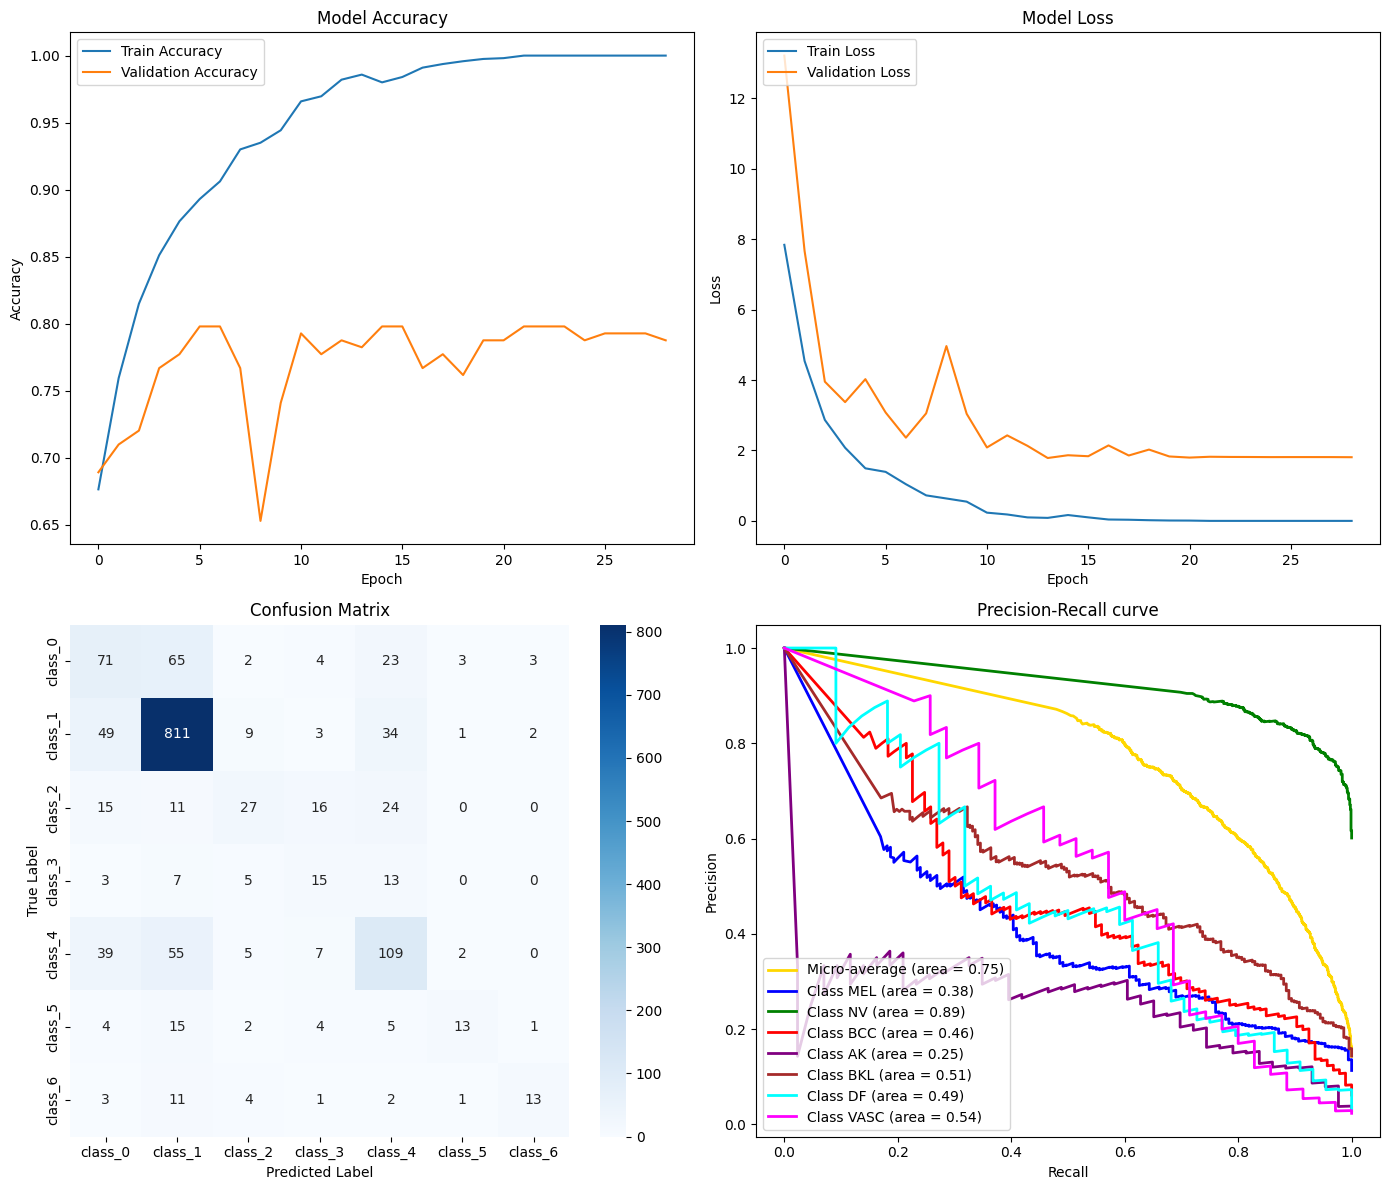

In [24]:
from tensorflow.keras.models import load_model

model = load_model('models/best_model_iteration_1.h5')

show_all_plots(history2, model, test_generator)

### What did we learn????

- Overfitting:
    - yes, we think
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We do not overfit, so we can try with a more complex model?
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

## Iteration 2

This is a script to test what learning rate we should use (and scheduler)

In [2]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Now you can import TensorFlow and run your code
import tensorflow as tf

# Your training code here


In [ ]:

from keras.optimizers import SGD
from tensorflow.keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])






# Custom callback to record the learning rate at each epoch
class LearningRateTracker(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Check if learning rate is a callable schedule (like InverseTimeDecay)
        if callable(self.model.optimizer.learning_rate):
            # Get current learning rate by calling the schedule with the current step
            step = self.model.optimizer.iterations
            lr = self.model.optimizer.learning_rate(step).numpy()
        else:
            # Directly access learning rate if it's a fixed value
            lr = self.model.optimizer.learning_rate.numpy()
        
        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)


# To store learning rates per decay strategy
learning_rates_dict = {}



total_number_of_images = train_generator.samples



initial_lr = 0.01
decay_rate = initial_lr * 0.01
# Learning rate decay functions
def linear_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr - decay_rate * epoch

initial_lr = 0.01
decay_rate = 0.1
def inverse_sqrt_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr / np.sqrt(1 + decay_rate * epoch)

initial_lr = 0.01
drop = 0.5
epochs_drop = 1/5 * epochs
def step_decay(epoch, initial_lr=initial_lr, drop=drop, epochs_drop=epochs_drop):
    return initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))


fraction = 0.1
total_number_trainingsteps = (total_number_of_images / batch_size) * epochs

initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.5
inverse_time_decay = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate)


starter_learning_rate = 0.1
end_learning_rate = starter_learning_rate * 0.1 
decay_steps = total_number_trainingsteps * 0.75
power = 0.3

print("decay steps", decay_steps)

polynomial_decay = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=starter_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power
)


initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.96
exponential_decay = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


sgd_configs = {}
#sgd_configs.update({f'cosine_with_warmup_decay': SGD(learning_rate=cosine_with_warmup_decay)})
sgd_configs.update({f'inverse_time_decay': SGD(learning_rate=inverse_time_decay)})
sgd_configs.update({f'polynomial_decay': SGD(learning_rate=polynomial_decay)})
sgd_configs.update({f'exponential_decay': SGD(learning_rate=exponential_decay)})
sgd_configs.update({f'constant': SGD(learning_rate=0.001)})



config_callbacks = {
    'linear_decay': {
        'callback': LearningRateScheduler(lambda epoch: linear_decay(epoch)),
    },
    'inverse_sqrt_decay': {
        'callback': LearningRateScheduler(lambda epoch: inverse_sqrt_decay(epoch)),
    },
    'step_decay': {
        'callback': LearningRateScheduler(lambda epoch: step_decay(epoch)),
    },
}

results = {}

for key in config_callbacks:

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
    lr_tracker = LearningRateTracker()
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[config_callbacks[key]['callback'], lr_tracker])

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[f"{key}"] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')


for key in sgd_configs:

    sgd = sgd_configs[key]

    lr_tracker = LearningRateTracker()

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[lr_tracker]
    )

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[key] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')




# Plotting learning rate decay over time for each configuration
plt.figure(figsize=(12, 8))
for key, lrs in learning_rates_dict.items():
    plt.plot(range(len(lrs)), lrs, label=f'{key} LR decay')

plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Comparison')
plt.legend()
plt.show()

for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.
decay steps 11736.328125
Epoch 1/50
313/313 [==============================] - 64s 196ms/step - loss: 8.2374 - accuracy: 0.6707 - val_loss: 3.0076 - val_accuracy: 0.7720 - lr: 0.0100
Epoch 2/50
313/313 [==============================] - 20s 65ms/step - loss: 4.3848 - accuracy: 0.7619 - val_loss: 2.5217 - val_accuracy: 0.7927 - lr: 0.0099
Epoch 3/50
313/313 [==============================] - 20s 65ms/step - loss: 2.7119 - accuracy: 0.8227 - val_loss: 4.8813 - val_accuracy: 0.7150 - lr: 0.0098
Epoch 4/50
313/313 [==============================] - 20s 64ms/step - loss: 2.1482 - accuracy: 0.8469 - val_loss: 3.9077 - val_accuracy: 0.7513 - lr: 0.0097
Epoch 5/50
313/313 [==============================] - 21s 66ms/step - loss: 1.5558 - accuracy: 0.8753 - val_loss: 2.4586 - val_accuracy: 0.8031 - lr: 0.0096
Epoch 6/50
313/313 [==============================] - 21s 66ms/

linear_decay: val_acc: 0.7979274392127991, val_loss: 1.8466776609420776


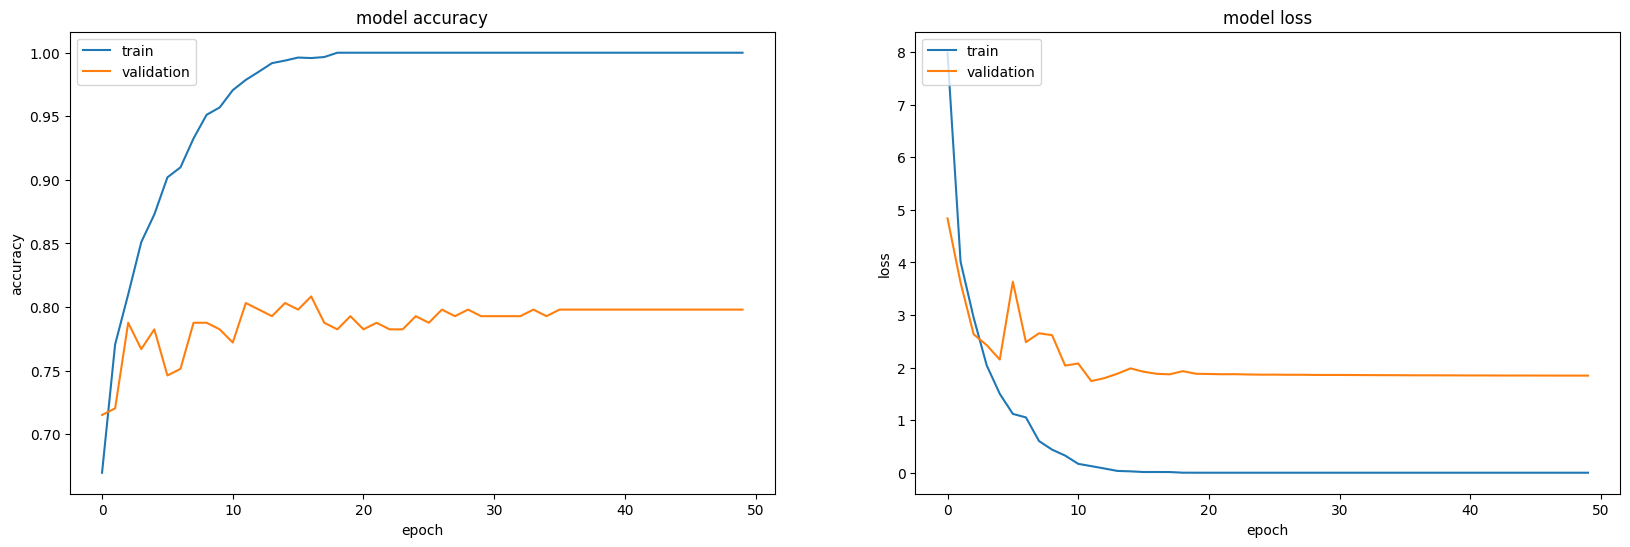

inverse_sqrt_decay: val_acc: 0.7979274392127991, val_loss: 1.557247519493103


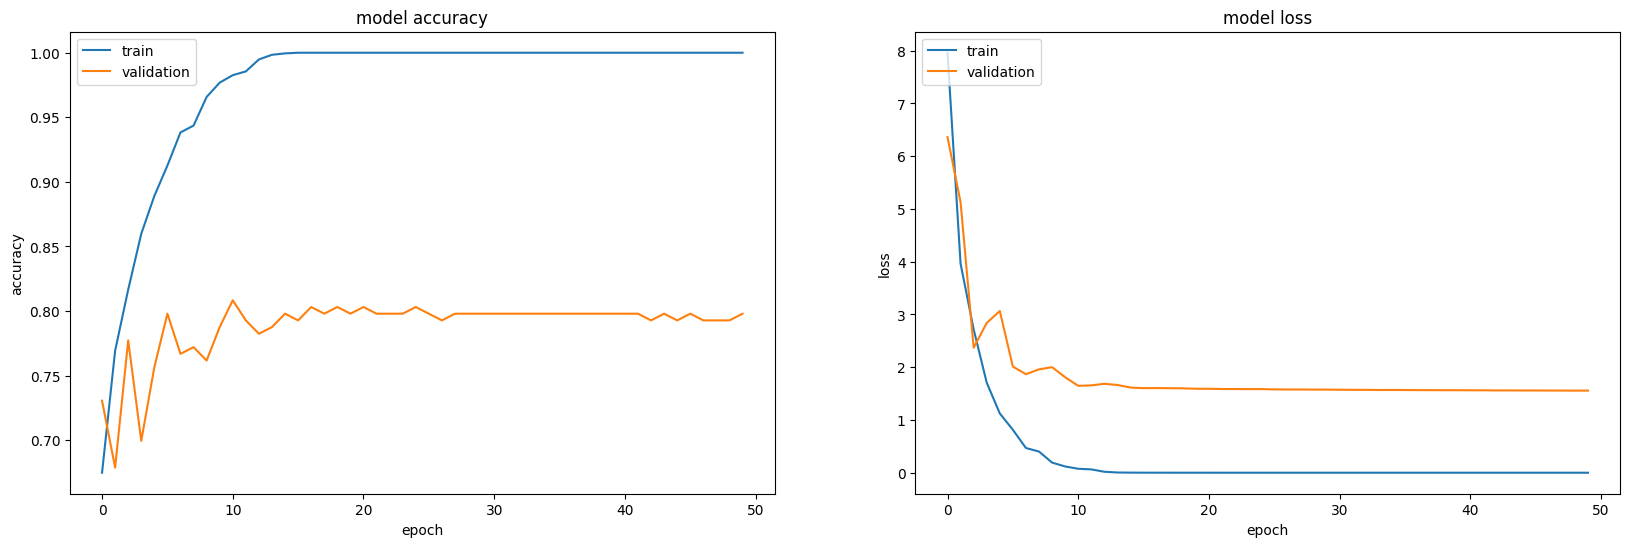

step_decay: val_acc: 0.8082901835441589, val_loss: 1.8573381900787354


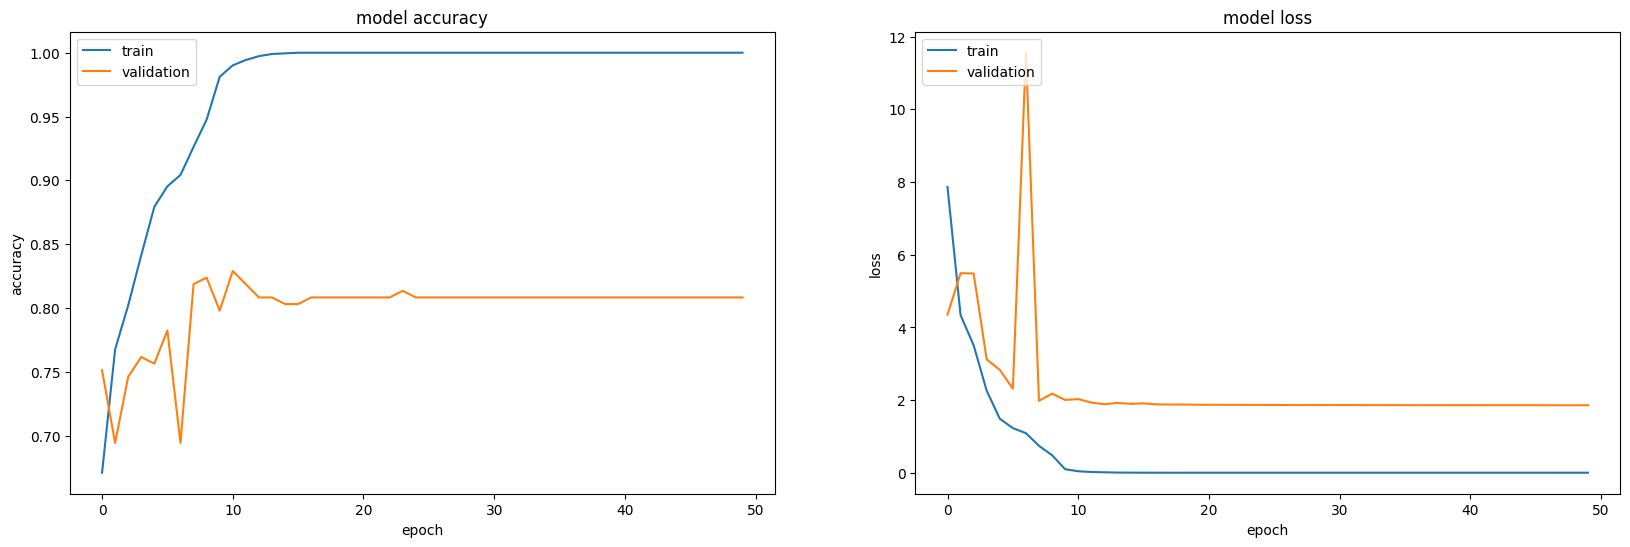

inverse_time_decay: val_acc: 0.7979274392127991, val_loss: 4.162773609161377


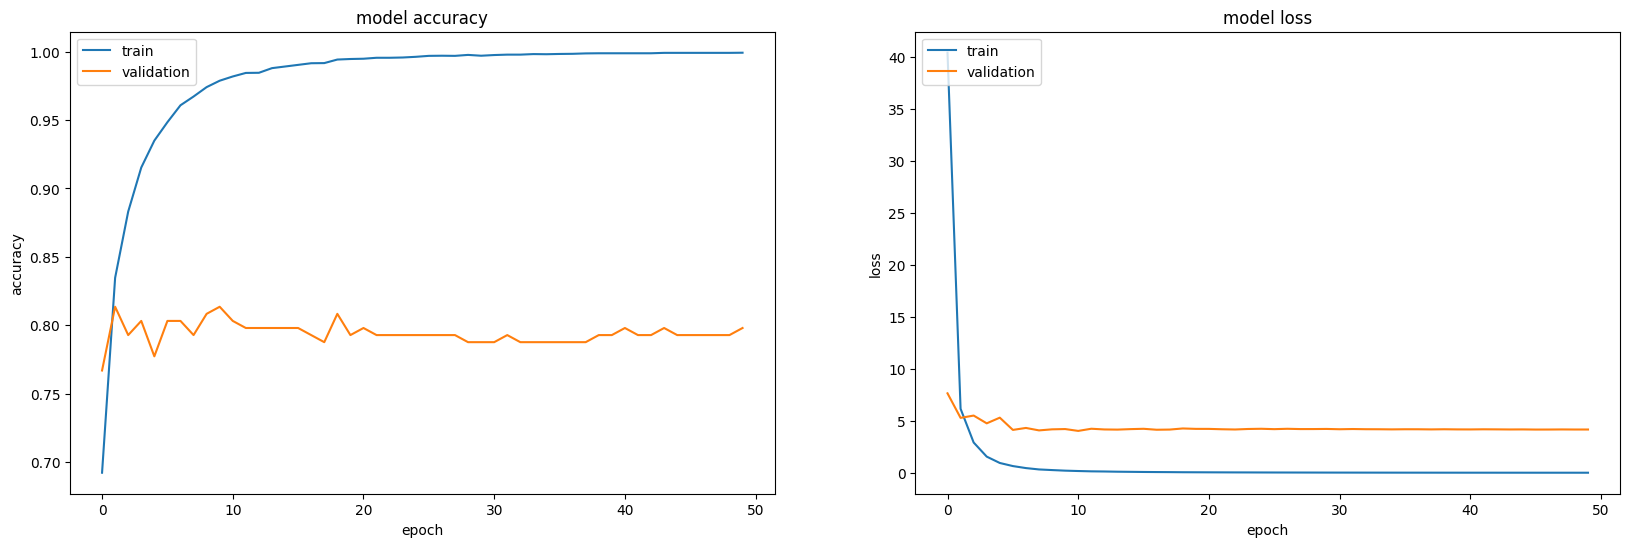

polynomial_decay: val_acc: 0.772020697593689, val_loss: 8.179764747619629


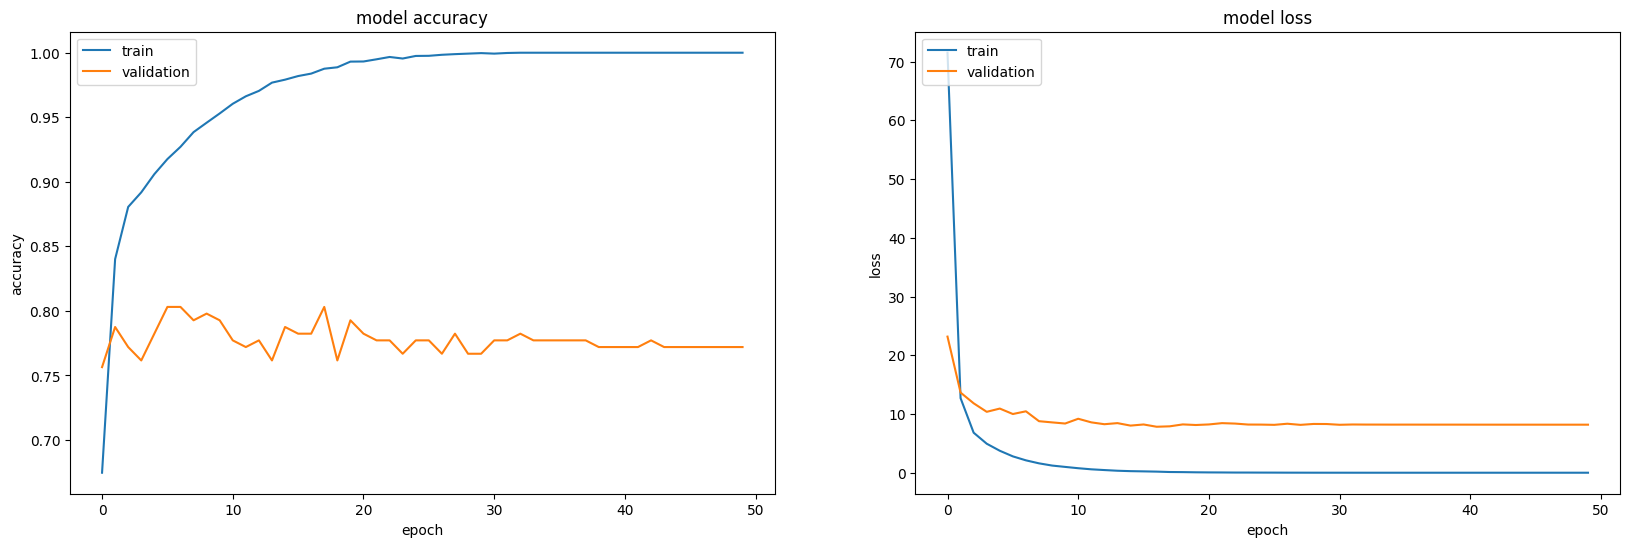

exponential_decay: val_acc: 0.7772020697593689, val_loss: 11.33125114440918


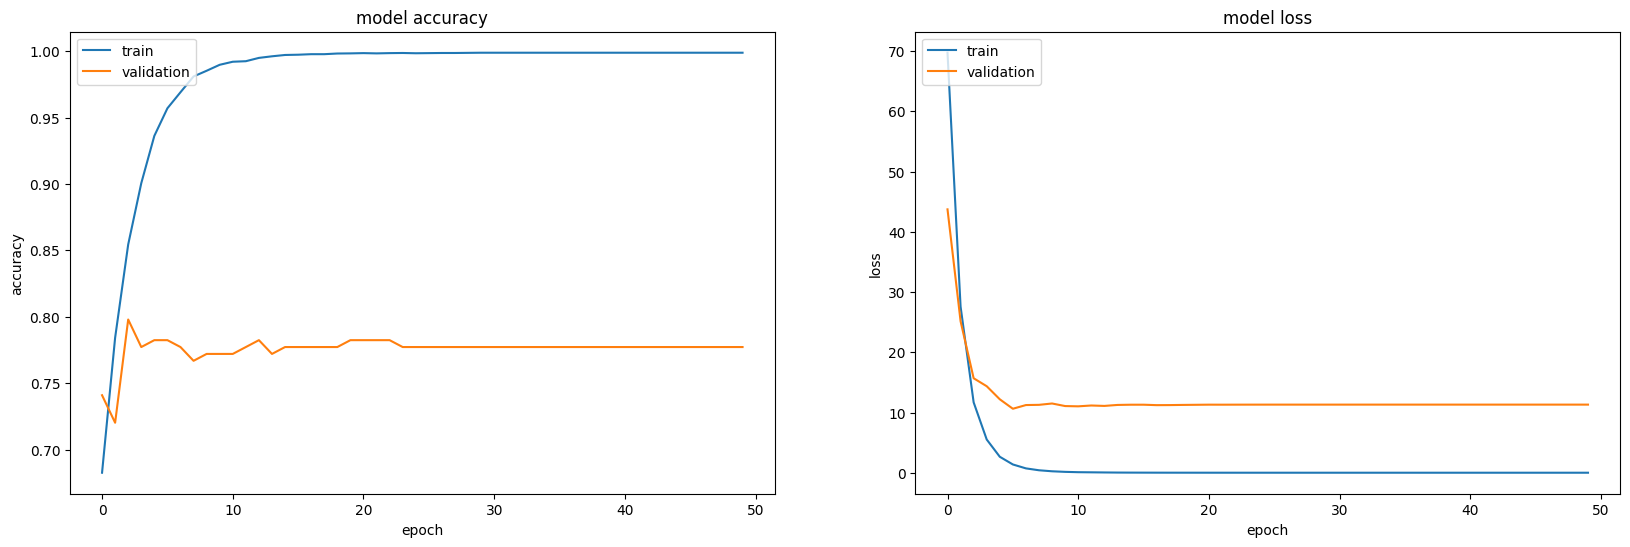

constant: val_acc: 0.787564754486084, val_loss: 0.5415298938751221


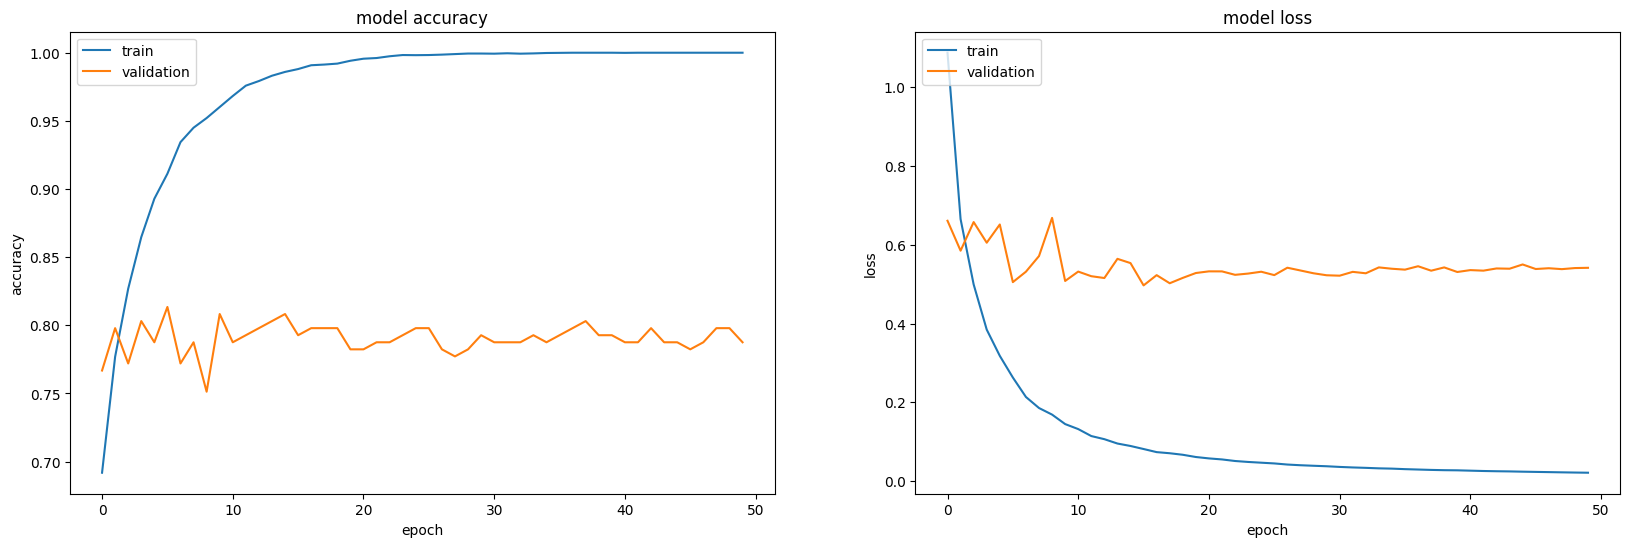

In [8]:
for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")
    show_history(history)

## Iteration 3

Here we experiment with LR rate. In particular we use "Jeremy's approch" with cyclic learning rate.

In [14]:
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [15]:
model = CustomModel(number_of_samples=train_generator.samples)

model.compile()

In [16]:
history_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path='models/best_model_iteration_3.h5')

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.6852
Epoch 1: val_loss improved from inf to 0.66021, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 33s 98ms/step - loss: 1.0104 - accuracy: 0.6852 - val_loss: 0.6602 - val_accuracy: 0.7927
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.7647
Epoch 2: val_loss improved from 0.66021 to 0.63225, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 30s 96ms/step - loss: 0.6893 - accuracy: 0.7647 - val_loss: 0.6323 - val_accuracy: 0.8031
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8007
Epoch 3: val_loss improved from 0.63225 to 0.57398, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 33s 105ms/step - loss: 0.5598 - accuracy: 0.8007 - val_loss: 0.5740 - val_accuracy: 0.8135
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.8274
Epoch 4: val_loss did not improve from 0.57398
313/313 [==============================] - 29s 91ms/step - loss: 0.4814 - accuracy: 0.8274 - val_loss: 0.6515 - val_accuracy: 0.7617
Epoch 5/5
313/313 [==============================] - ETA: 0s - loss: 0.3988 

All layers have been unfrozen.
32 312.96875 3129.6875
Epoch 1/10
313/313 [==============================] - 100s 313ms/step - loss: 1.1915 - accuracy: 0.6868 - val_loss: 0.8325 - val_accuracy: 0.7565
Epoch 2/10
313/313 [==============================] - 96s 306ms/step - loss: 0.7534 - accuracy: 0.7726 - val_loss: 1.3183 - val_accuracy: 0.6995
Epoch 3/10
313/313 [==============================] - 98s 314ms/step - loss: 0.4486 - accuracy: 0.8506 - val_loss: 1.1096 - val_accuracy: 0.7098
Epoch 4/10
313/313 [==============================] - 96s 306ms/step - loss: 0.2508 - accuracy: 0.9122 - val_loss: 1.0725 - val_accuracy: 0.7409
Epoch 5/10
313/313 [==============================] - 96s 306ms/step - loss: 0.1343 - accuracy: 0.9524 - val_loss: 1.0781 - val_accuracy: 0.7772
Epoch 6/10
313/313 [==============================] - 96s 306ms/step - loss: 0.0947 - accuracy: 0.9667 - val_loss: 1.0525 - val_accuracy: 0.7565
Epoch 7/10
313/313 [==============================] - 99s 315ms/step - loss

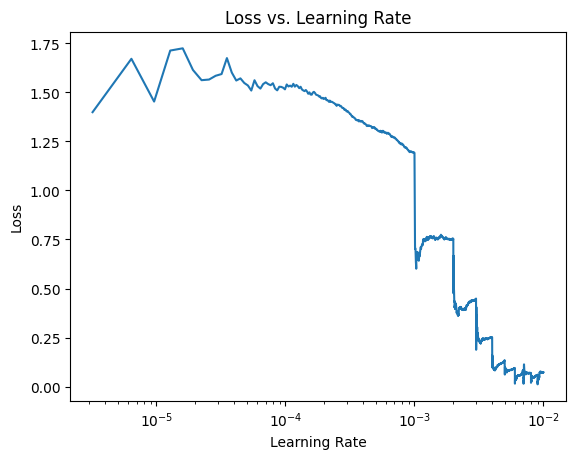

In [17]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [18]:
history = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path='models/best_model_iteration_3.h5', lr=[1e-4, 1e-3])

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9877
Epoch 1: val_loss improved from inf to 1.09188, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 106s 338ms/step - loss: 0.0353 - accuracy: 0.9877 - val_loss: 1.0919 - val_accuracy: 0.7720
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9918
Epoch 2: val_loss improved from 1.09188 to 1.08380, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 96s 306ms/step - loss: 0.0235 - accuracy: 0.9918 - val_loss: 1.0838 - val_accuracy: 0.7720
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9931
Epoch 3: val_loss improved from 1.08380 to 1.07951, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 94s 301ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 1.0795 - val_accuracy: 0.7772
Epoch 4/50

Balanced Accrucay: 0.5043077761088417
Accuracy on test set: 0.7116402387619019
F1 Score: 0.7000921830165115


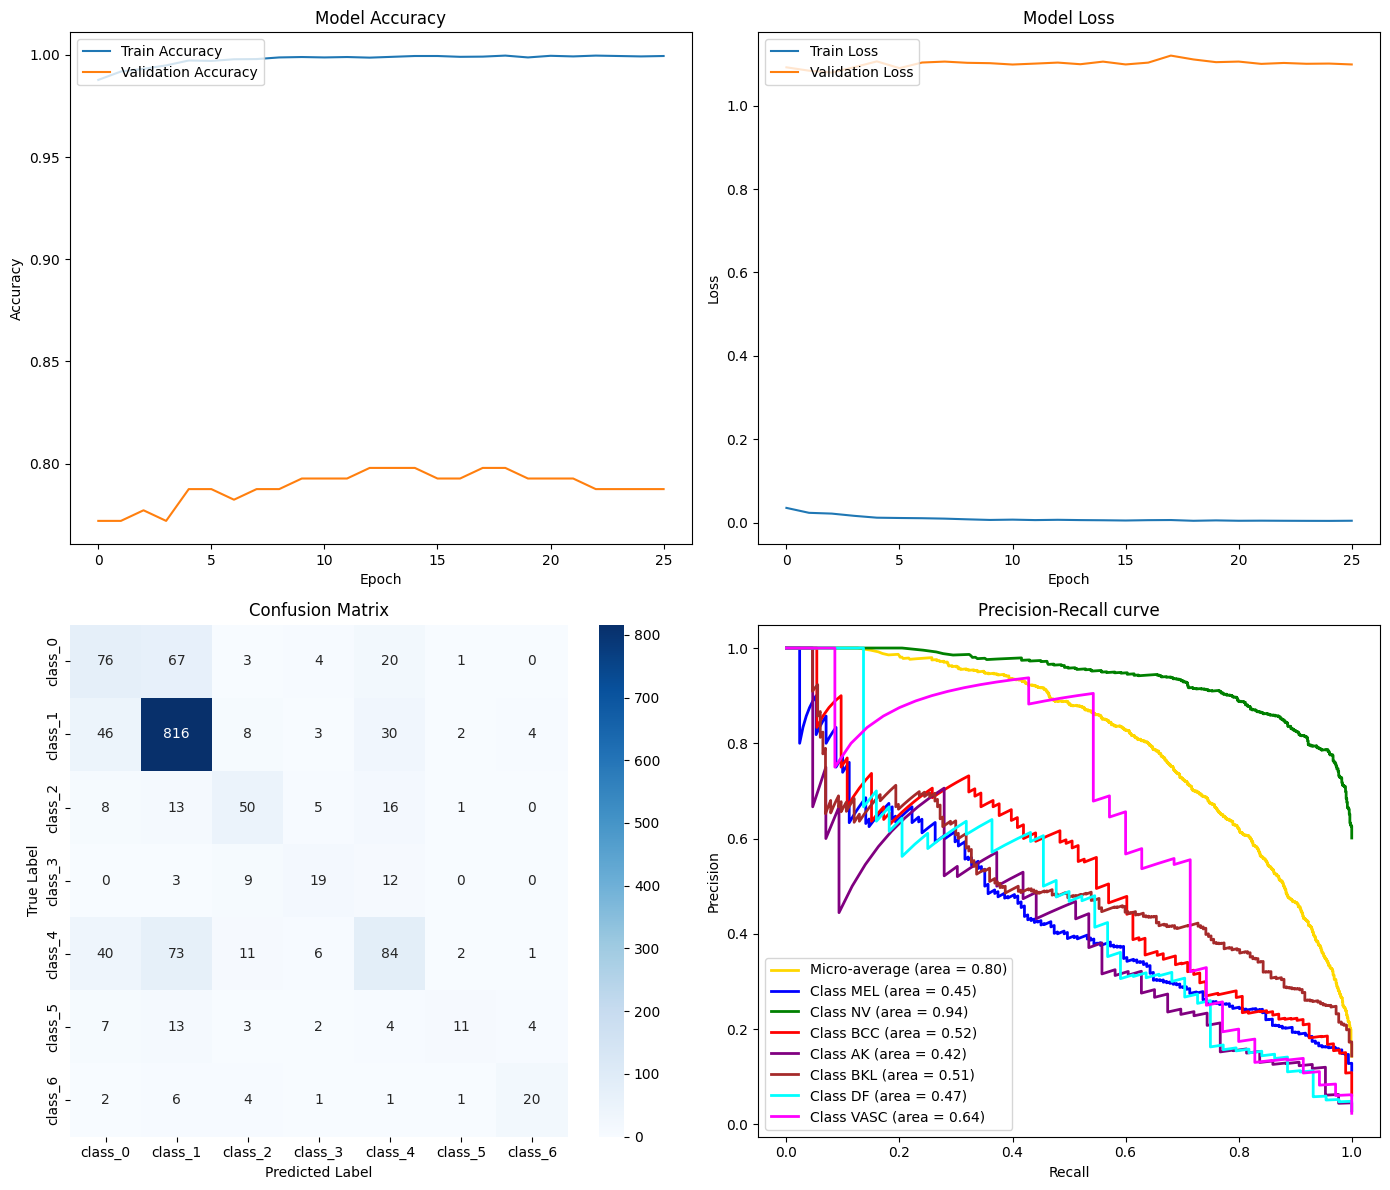

In [21]:
from tensorflow.keras.models import load_model

model = load_model('models/best_model_iteration_3.h5')

show_all_plots(history, model, test_generator)

### What did we learn????

- Overfitting:
    - Big gap between train / val means overfitting (slide 91) it just cant generelize 
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=82.72, test: 71.42
    - loss -> train=fuckinglav, val=0.56, test=1.22

Takaways:
- It doesnt learn that well for val/test and there is a large gap between train and the others
- Very unbalanced learning - its very good at the class with the most data
- We think its a problem that the validation set is very small ( we have just taken what we godt from the dataset split from the challange).
    It gives a high variance in the perfomance metrics. 

Did we do what we wanted?
- a bit, we got a lower loss but we still plateau pretty quickly. It is probably becuase we have better initialization of the lr so the loss doesnt get too crazy but it still need to get lower.

What to do next time?
- We should fix the train/test/val split
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training
- Experiment with making it better at learning all classes (it gives an inflated look at the accuracy as the validation/test set will have many pictures of class 1)
    - under/over sample classes to have the same number of images (best idea to have this per batch)
    - Weighted loss function


## Iteration 4 

Made our own dataloader that split the data set. Everything else should be normal.

In [ ]:

from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory

data_dir = "../../Merge Set Ordered"
batch_size=32
dist = []
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

0
Found 8202 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [ ]:
from homemade_model_iteration_4 import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path='../../models/best_model_iteration_4.h5')
histories.append(history1)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.6759
Epoch 1: val_loss improved from inf to 0.87076, saving model to ../../models/best_model_iteration_4.h5
256/256 [==============================] - 31s 115ms/step - loss: 1.0477 - accuracy: 0.6759 - val_loss: 0.8708 - val_accuracy: 0.7118
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.7524
Epoch 2: val_loss did not improve from 0.87076
256/256 [==============================] - 28s 111ms/step - loss: 0.7231 - accuracy: 0.7524 - val_loss: 0.8715 - val_accuracy: 0.7130
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7916
Epoch 3: val_loss improved from 0.87076 to 0.76015, saving model to ../../models/best_model_iteration_4.h5
256/256 [==============================] - 28s 111ms/step - loss: 0.5841 - accuracy: 0.7916 - val_loss: 0.7601 - val_accuracy: 0.7471
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.8240
Epoch 4: val_loss did not improve from 0.76015
256/256 [==============================] - 28s 110ms/step - loss: 0.4849 - accuracy: 0.8240 - val_loss: 0.7728 - val_accuracy: 0.7558
Epoch 5/5
256/256 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8544
Epoch 5: val_loss did not i

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 92s 352ms/step - loss: 1.2532 - accuracy: 0.6772 - val_loss: 1.0514 - val_accuracy: 0.7442
Epoch 2/10
256/256 [==============================] - 89s 348ms/step - loss: 0.7902 - accuracy: 0.7762 - val_loss: 1.2388 - val_accuracy: 0.7355
Epoch 3/10
256/256 [==============================] - 88s 343ms/step - loss: 0.4393 - accuracy: 0.8563 - val_loss: 1.2693 - val_accuracy: 0.7292
Epoch 4/10
256/256 [==============================] - 91s 353ms/step - loss: 0.2477 - accuracy: 0.9149 - val_loss: 1.0542 - val_accuracy: 0.7286
Epoch 5/10
256/256 [==============================] - 89s 347ms/step - loss: 0.1468 - accuracy: 0.9507 - val_loss: 1.0437 - val_accuracy: 0.7442
Epoch 6/10
256/256 [==============================] - 90s 350ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 1.2740 - val_accuracy: 0.7593
Epoch 7/10
256/256 [==============================] - 89s 345ms/step - loss: 0.0803 - accuracy: 0.9

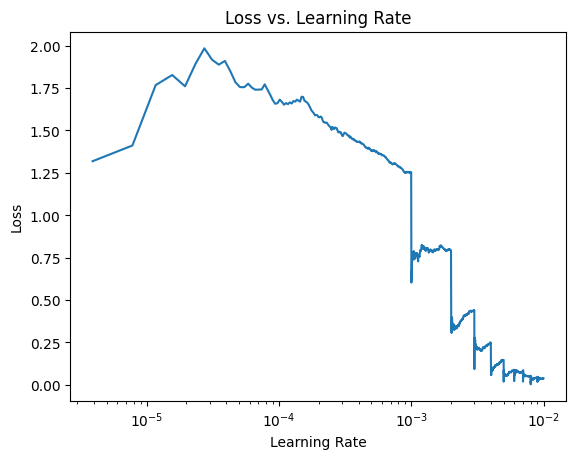

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
history2 = model.fit_epochs(train_generator, 
        validation_generator, 
        epochs=50, 
        checkpoint_path='../../models/best_model_iteration_4.h5', 
        lr=[1e-4, 2e-3])
histories.append(history2)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9948
Epoch 1: val_loss improved from inf to 1.19904, saving model to ../../models/best_model_iteration_4.h5
256/256 [==============================] - 96s 374ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 1.1990 - val_accuracy: 0.7766
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9963
Epoch 2: val_loss improved from 1.19904 to 1.18970, saving model to ../../models/best_model_iteration_4.h5
256/256 [==============================] - 90s 349ms/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 1.1897 - val_accuracy: 0.7795
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9971
Epoch 3: val_loss improved from 1.18970 to 1.17265, saving model to ../../models/best_model_iteration_4.h5
256/256 [==============================] - 88s 343ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 1.1726 - val_accuracy: 0.7795
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9979
Epoch 4: val_loss did not improve from 1.17265
256/256 [==============================] - 88s 343ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 1.1790 - val_accuracy: 0.7830
Epoch 5/50
256/256 [==============================] - ETA: 0

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.5571815561114686
Accuracy on test set: 0.7719907164573669
F1 Score: 0.7639273325780261


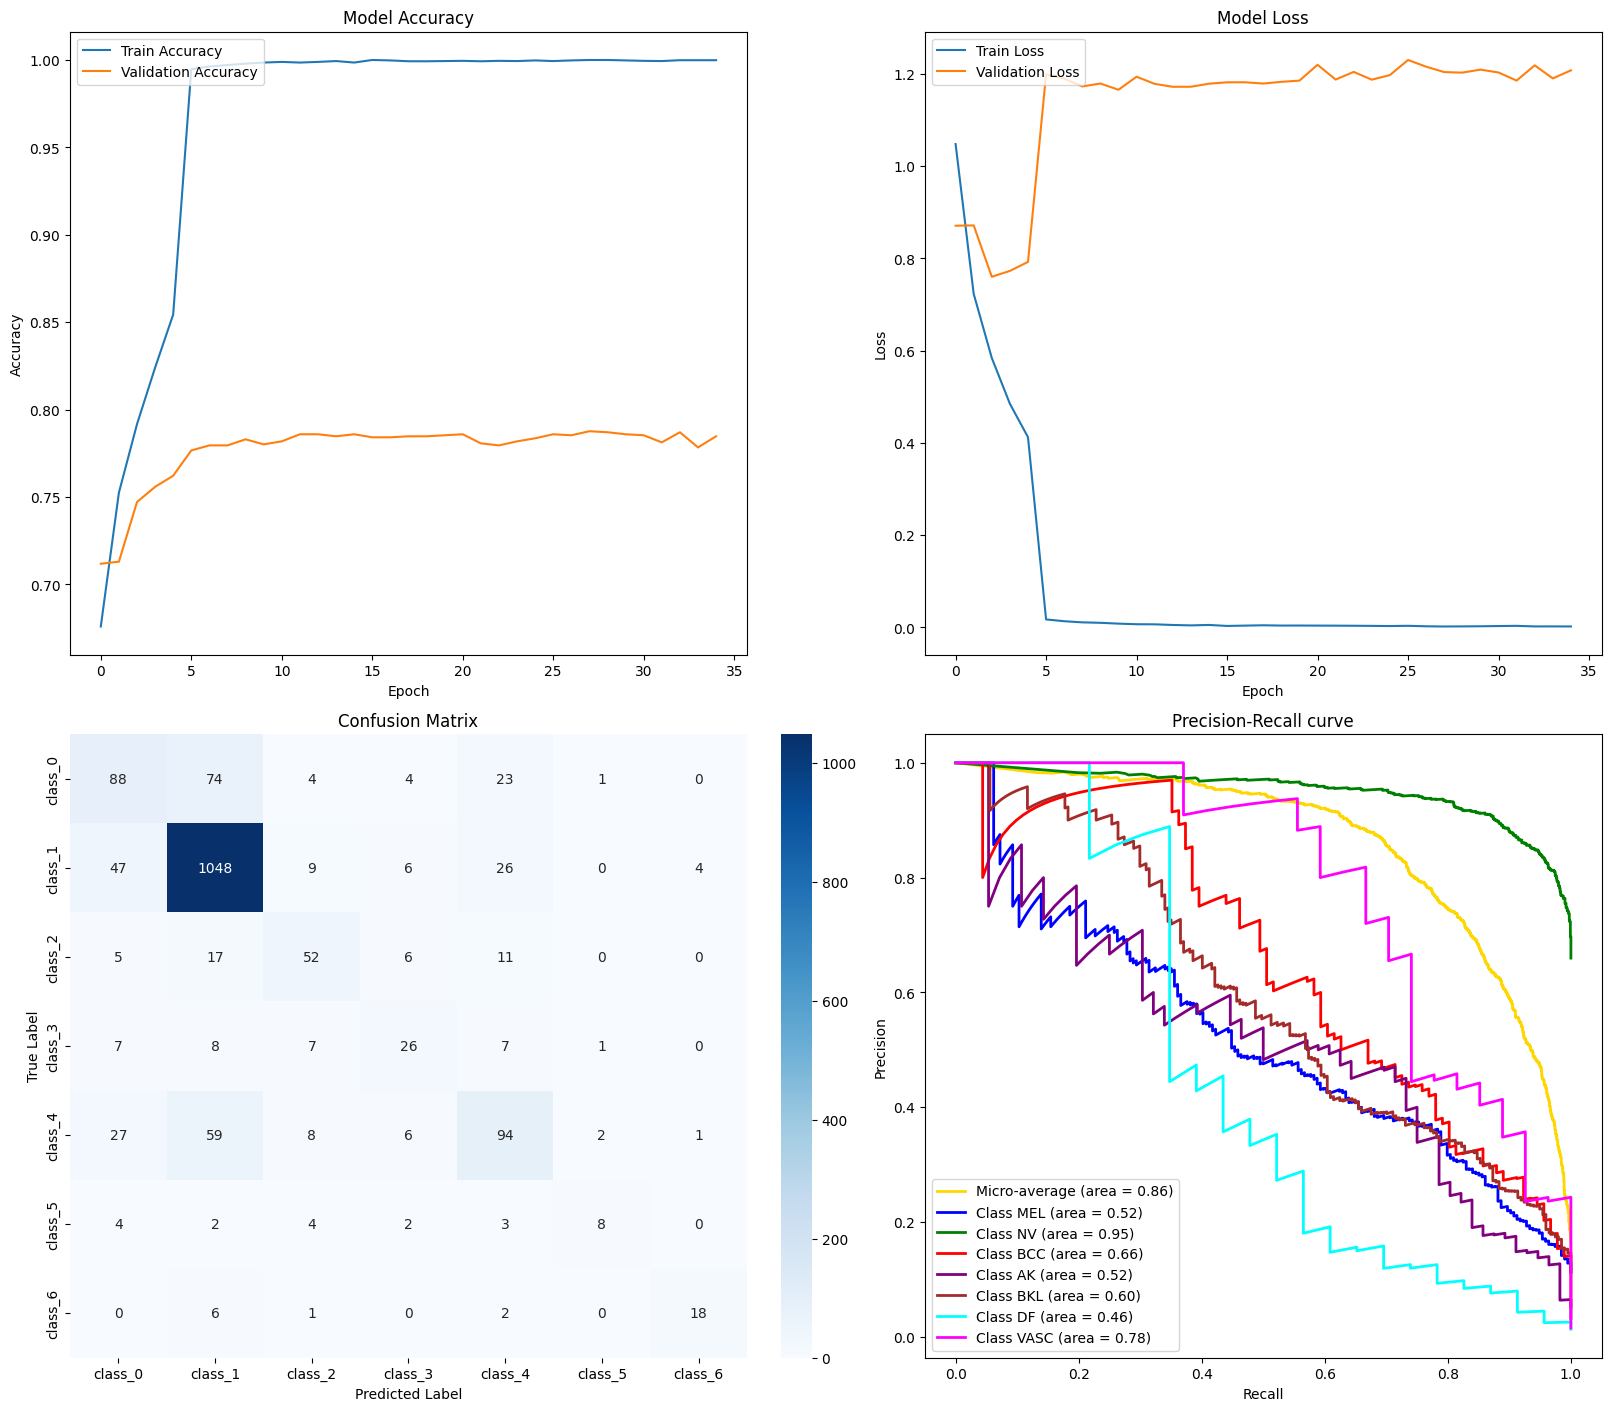

In [ ]:
import sys
import os
from tensorflow.keras.models import load_model


m = load_model('../../models/best_model_iteration_4.h5')

show_all_plots(histories, m, test_generator)

### What did we learn?

It is almost the exact same as before

Whose to next time make the model better at all classes so that the meetrics are a better representation of how the model is doing and not just because the is one class with a lot of data. 



In [ ]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_5_2"
model_dir = f'../../models/best_model_{iteration}.h5'


In [ ]:

from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [ ]:

import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 2.0066 - accuracy: 0.3402
Epoch 1: val_loss improved from inf to 1.28990, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 76s 294ms/step - loss: 2.0066 - accuracy: 0.3402 - val_loss: 1.2899 - val_accuracy: 0.5567
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 1.5690 - accuracy: 0.4601
Epoch 2: val_loss improved from 1.28990 to 1.17582, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 78s 306ms/step - loss: 1.5690 - accuracy: 0.4601 - val_loss: 1.1758 - val_accuracy: 0.6123
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.4965
Epoch 3: val_loss did not improve from 1.17582
256/256 [==============================] - 80s 311ms/step - loss: 1.4560 - accuracy: 0.4965 - val_loss: 1.1809 - val_accuracy: 0.5949
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 1.3915 - accuracy: 0.5161
Epoch 4: val_loss improved from 1.17582 to 1.05107, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 81s 318ms/step - loss: 1.3915 - accuracy: 0.5161 - val_loss: 1.0511 - val_accuracy: 0.6678
Epoch 5/5
256/256 [==============================] - ETA: 

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 120s 462ms/step - loss: 2.1560 - accuracy: 0.4081 - val_loss: 1.1214 - val_accuracy: 0.6875
Epoch 2/10
256/256 [==============================] - 130s 508ms/step - loss: 1.7556 - accuracy: 0.4885 - val_loss: 1.3002 - val_accuracy: 0.6939
Epoch 3/10
256/256 [==============================] - 142s 555ms/step - loss: 1.5019 - accuracy: 0.5413 - val_loss: 1.2314 - val_accuracy: 0.6406
Epoch 4/10
256/256 [==============================] - 119s 462ms/step - loss: 1.2704 - accuracy: 0.5775 - val_loss: 0.9630 - val_accuracy: 0.6904
Epoch 5/10
256/256 [==============================] - 127s 494ms/step - loss: 1.1459 - accuracy: 0.6029 - val_loss: 0.9767 - val_accuracy: 0.6939
Epoch 6/10
256/256 [==============================] - 119s 464ms/step - loss: 1.0460 - accuracy: 0.6257 - val_loss: 1.0000 - val_accuracy: 0.6742
Epoch 7/10
256/256 [==============================] - 105s 410ms/step - loss: 0.9809 - accura

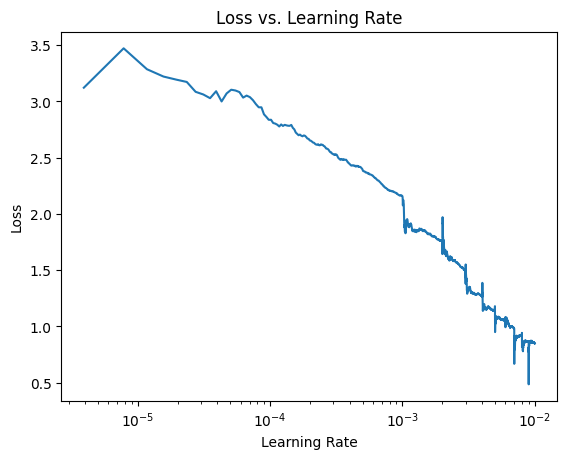

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir, lr=[1e-4, 1e-3])
histories.append(history2)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.7013
Epoch 1: val_loss improved from inf to 1.07193, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 104s 402ms/step - loss: 0.7989 - accuracy: 0.7013 - val_loss: 1.0719 - val_accuracy: 0.6713
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7032
Epoch 2: val_loss improved from 1.07193 to 0.98818, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 97s 379ms/step - loss: 0.7858 - accuracy: 0.7032 - val_loss: 0.9882 - val_accuracy: 0.6956
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7100
Epoch 3: val_loss improved from 0.98818 to 0.95300, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 96s 373ms/step - loss: 0.7861 - accuracy: 0.7100 - val_loss: 0.9530 - val_accuracy: 0.7066
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.7220
Epoch 4: val_loss improved from 0.95300 to 0.93590, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 90s 351ms/step - loss: 0.7515 - accuracy: 0.7220 - val_loss: 0.9359 - val_accuracy: 0

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6893861792426973
Accuracy on test set: 0.7453703880310059
F1 Score: 0.7537624875609487


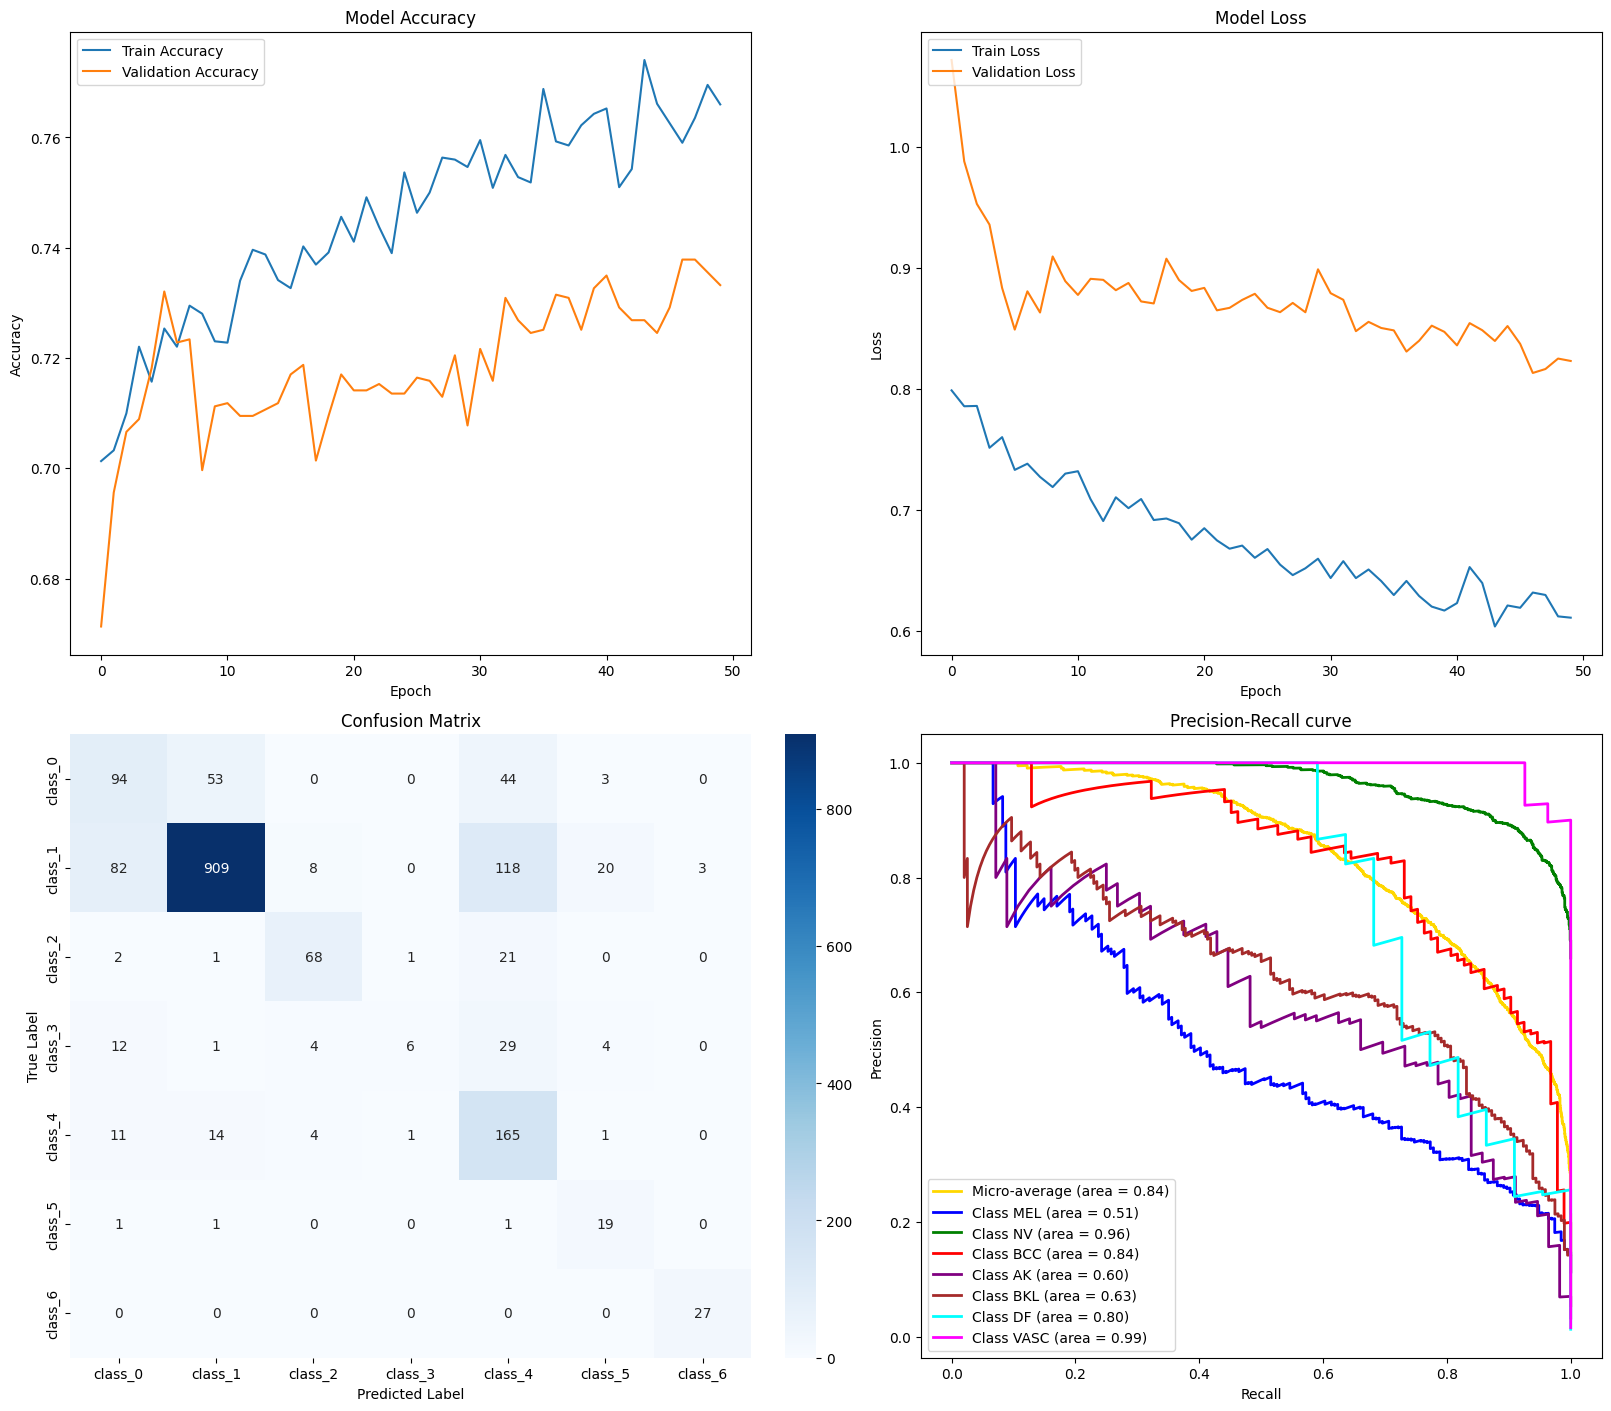

In [ ]:

from plot_utils import show_all_plots
from tensorflow.keras.models import load_model

m = load_model(model_dir)
histories = [history1, history2]
show_all_plots(history2, m, test_generator)

## Iteration 5.1

In [ ]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_5_1"
model_dir = f'../../models/best_model_{iteration}.h5'


In [ ]:

from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [115,115,115,115,115,115,115]
print(sum(dist))

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

2024-11-21 14:59:39.197947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 14:59:39.453740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 14:59:39.456364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:59:40.760324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


805
Training set
Found 8202 images belonging to 7 classes (dist says 805)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [ ]:
import numpy as np
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']

def print_sample_distribution(dataloader, class_names):
    """Print the distribution of samples per class for each batch and overall."""

    # Initialize total counts for all classes
    total_class_counts = {class_name: 0 for class_name in class_names}

    # Per-batch distribution
    print("\nDistribution of samples per class for each batch:")
    print("Number of batches:", len(dataloader))
    for batch_idx in range(len(dataloader)):
        # Fetch batch data
        img, labels = dataloader[batch_idx]

        # Count occurrences of each class in the batch
        batch_class_counts = {class_name: 0 for class_name in class_names}
        for label_vector in labels:
            class_index = np.argmax(label_vector)  # Convert one-hot to class index
            batch_class_counts[class_names[class_index]] += 1
            total_class_counts[class_names[class_index]] += 1

        # Print batch distribution
        print(f"Batch {batch_idx + 1}:")
        for class_name, count in batch_class_counts.items():
            print(f"  Class '{class_name}': {count} samples")

    # Print overall distribution
    print("\nTotal distribution of samples across all batches:")
    for class_name, count in total_class_counts.items():
        print(f"  Class '{class_name}': {count} samples")





# Example usage with your defined dataloader
print("Train Generator Distribution:", test_generator.isValidation)
print_sample_distribution(train_generator, factory.class_names)

# print("\nValidation Generator Distribution:")
# print_sample_distribution(validation_generator, factory.class_names)

# print("\nTest Generator Distribution:")
# print_sample_distribution(test_generator, factory.class_names)



In [ ]:

import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
history = model.fit_epochs(train_generator, validation_generator, epochs=10, checkpoint_path=model_dir)

Epoch 1/10


2024-11-21 15:02:35.064935: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-11-21 15:02:35.115269: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-11-21 15:02:35.115325: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-11-21 15:02:35.136359: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26150912 exceeds 10% of free system memory.
2024-11-21 15:02:35.158705: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28901376 exceeds 10% of free system memory.


25/25 [==============================] - ETA: 0s - loss: 2.6440 - accuracy: 0.1975
Epoch 1: val_loss improved from inf to 2.47138, saving model to ../../models/best_model_iteration_5_1.h5


/home/renemartensen/Desktop/Aarhus universitet/Deep Learning/deep_learning_group2/mothermark_cancer_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 30s 1s/step - loss: 2.6440 - accuracy: 0.1975 - val_loss: 2.4714 - val_accuracy: 0.2251
Training set
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 2.5073 - accuracy: 0.2425
Epoch 2: val_loss improved from 2.47138 to 2.35690, saving model to ../../models/best_model_iteration_5_1.h5
25/25 [==============================] - 27s 1s/step - loss: 2.5073 - accuracy: 0.2425 - val_loss: 2.3569 - val_accuracy: 0.2390
Training set
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 2.1543 - accuracy: 0.2825
Epoch 3: val_loss improved from 2.35690 to 1.88780, saving model to ../../models/best_model_iteration_5_1.h5
25/25 [==============================] - 27s 1s/step - loss: 2.1543 - accuracy: 0.2825 - val_loss: 1.8878 - val_accuracy: 0.3553
Training set
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.8659 - accuracy: 0.3537
Epoch 4: val_loss improved from 1.88780 to 1.47373, saving model to ../../

All layers have been unfrozen.
Epoch 1/10
25/25 [==============================] - 46s 2s/step - loss: 2.7179 - accuracy: 0.3288 - val_loss: 1.3273 - val_accuracy: 0.5932
Training set
Epoch 2/10
25/25 [==============================] - 36s 1s/step - loss: 2.5424 - accuracy: 0.3462 - val_loss: 1.3068 - val_accuracy: 0.6667
Training set
Epoch 3/10
25/25 [==============================] - 35s 1s/step - loss: 2.5022 - accuracy: 0.3850 - val_loss: 1.5949 - val_accuracy: 0.6221
Training set
Epoch 4/10
25/25 [==============================] - 34s 1s/step - loss: 2.4503 - accuracy: 0.4112 - val_loss: 2.3448 - val_accuracy: 0.4722
Training set
Epoch 5/10
25/25 [==============================] - 34s 1s/step - loss: 2.5266 - accuracy: 0.4162 - val_loss: 2.3215 - val_accuracy: 0.5318
Training set
Epoch 6/10
25/25 [==============================] - 34s 1s/step - loss: 2.3582 - accuracy: 0.4588 - val_loss: 2.0440 - val_accuracy: 0.5909
Training set
Epoch 7/10
25/25 [==============================] -

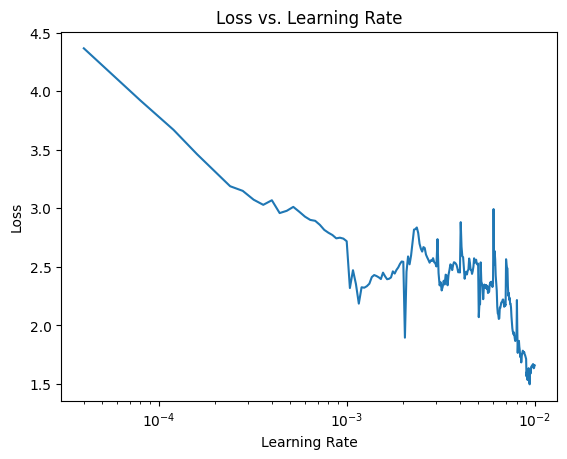

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
history = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir, lr=[1e-5, 5e-3])

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.6982 - accuracy: 0.4825
Epoch 1: val_loss improved from inf to 1.97176, saving model to ../../models/best_model_iteration_5_1.h5


/home/renemartensen/Desktop/Aarhus universitet/Deep Learning/deep_learning_group2/mothermark_cancer_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 34s 1s/step - loss: 1.6982 - accuracy: 0.4825 - val_loss: 1.9718 - val_accuracy: 0.5671
Training set
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5673 - accuracy: 0.5075
Epoch 2: val_loss improved from 1.97176 to 1.82878, saving model to ../../models/best_model_iteration_5_1.h5
25/25 [==============================] - 34s 1s/step - loss: 1.5673 - accuracy: 0.5075 - val_loss: 1.8288 - val_accuracy: 0.5868
Training set
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.4094 - accuracy: 0.5250
Epoch 3: val_loss improved from 1.82878 to 1.70525, saving model to ../../models/best_model_iteration_5_1.h5
25/25 [==============================] - 32s 1s/step - loss: 1.4094 - accuracy: 0.5250 - val_loss: 1.7053 - val_accuracy: 0.6181
Training set
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.3823 - accuracy: 0.5337
Epoch 4: val_loss did not improve from 1.70525
25/25 [====================

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.5869086247169345
Accuracy on test set: 0.6903935074806213
F1 Score: 0.7121234617315392


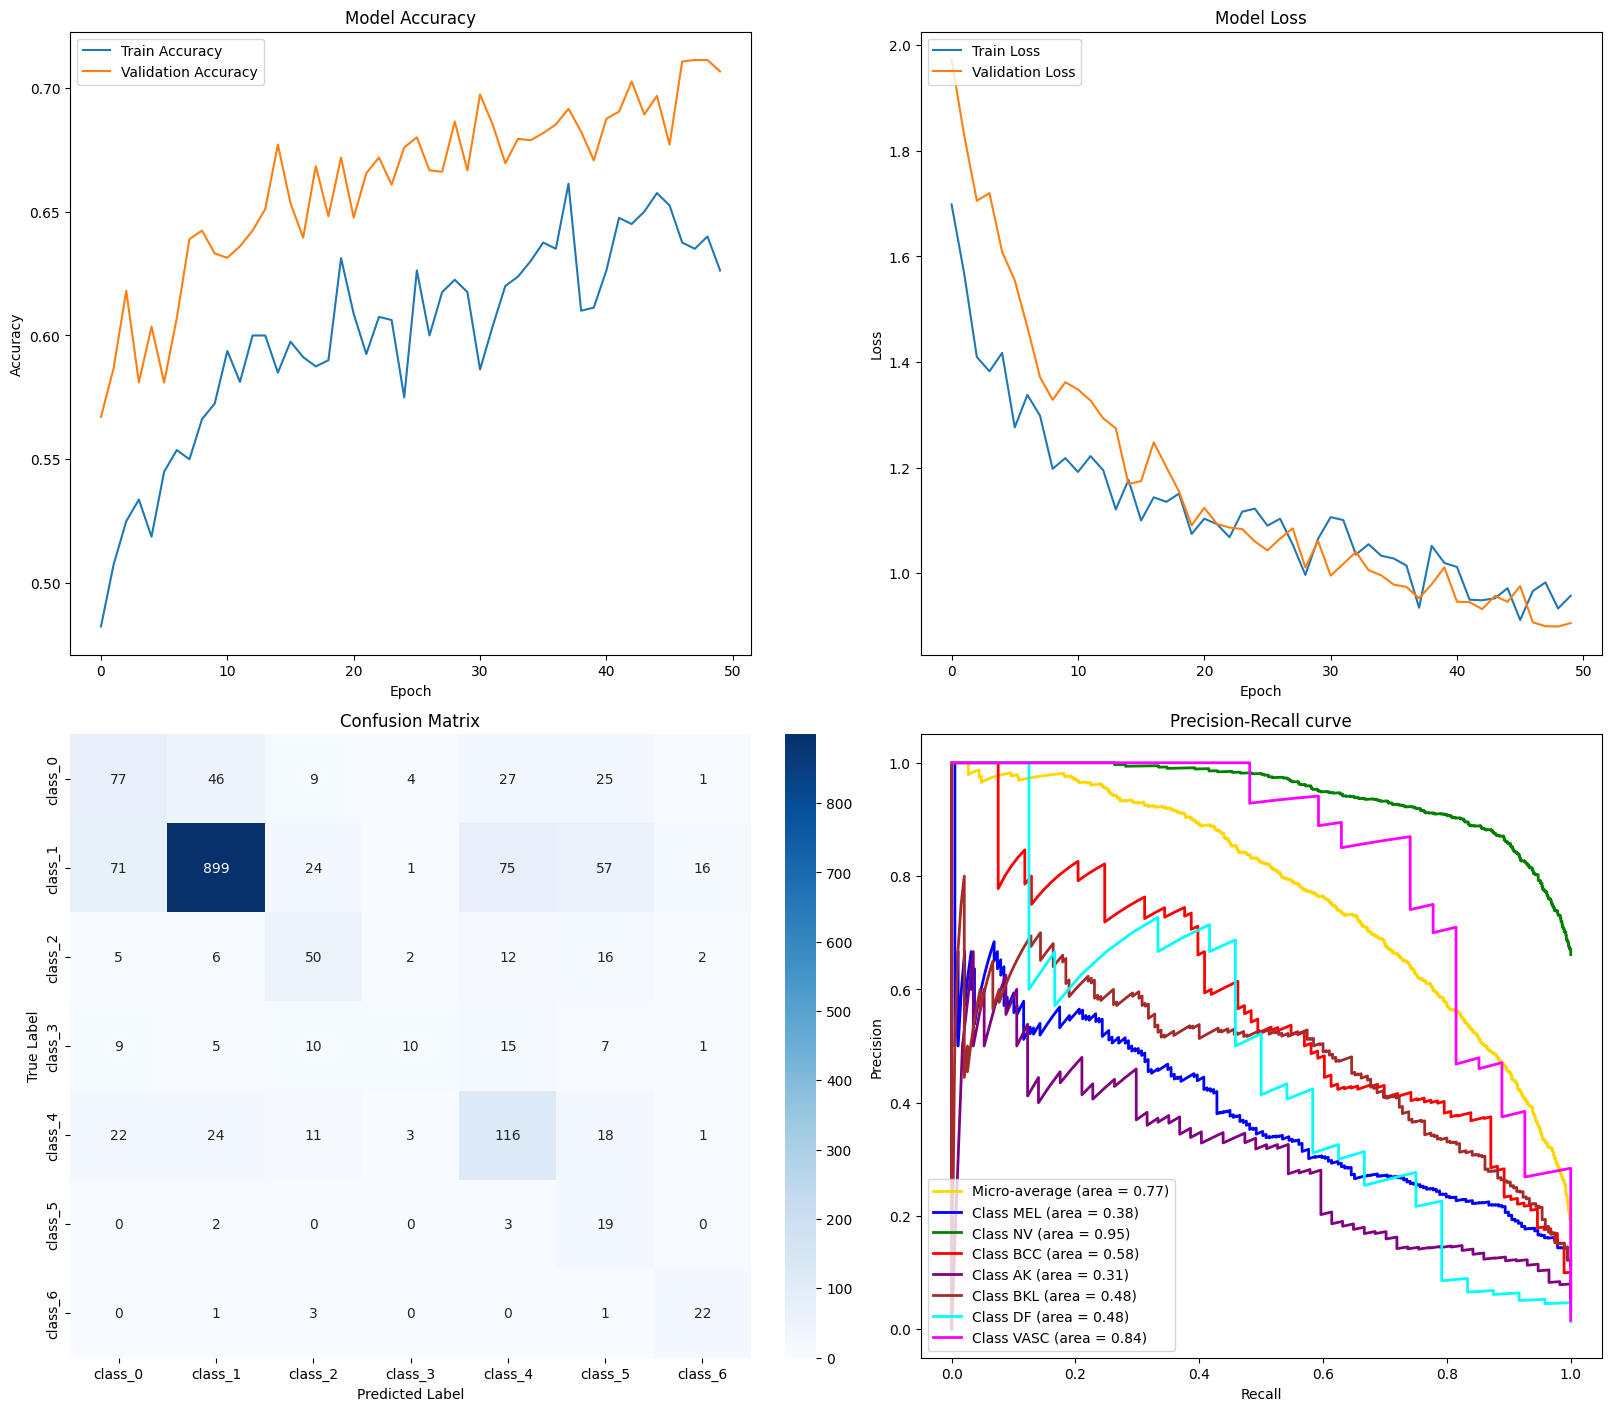

In [ ]:
from plot_utils import show_all_plots
from tensorflow.keras.models import load_model

m = load_model(model_dir)

show_all_plots(history, m, test_generator)

## Iteration 5.2

In [ ]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_5_2"
model_dir = f'../../models/best_model_{iteration}.h5'


In [ ]:

from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [ ]:

import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 2.0066 - accuracy: 0.3402
Epoch 1: val_loss improved from inf to 1.28990, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 76s 294ms/step - loss: 2.0066 - accuracy: 0.3402 - val_loss: 1.2899 - val_accuracy: 0.5567
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 1.5690 - accuracy: 0.4601
Epoch 2: val_loss improved from 1.28990 to 1.17582, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 78s 306ms/step - loss: 1.5690 - accuracy: 0.4601 - val_loss: 1.1758 - val_accuracy: 0.6123
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.4965
Epoch 3: val_loss did not improve from 1.17582
256/256 [==============================] - 80s 311ms/step - loss: 1.4560 - accuracy: 0.4965 - val_loss: 1.1809 - val_accuracy: 0.5949
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 1.3915 - accuracy: 0.5161
Epoch 4: val_loss improved from 1.17582 to 1.05107, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 81s 318ms/step - loss: 1.3915 - accuracy: 0.5161 - val_loss: 1.0511 - val_accuracy: 0.6678
Epoch 5/5
256/256 [==============================] - ETA: 

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 120s 462ms/step - loss: 2.1560 - accuracy: 0.4081 - val_loss: 1.1214 - val_accuracy: 0.6875
Epoch 2/10
256/256 [==============================] - 130s 508ms/step - loss: 1.7556 - accuracy: 0.4885 - val_loss: 1.3002 - val_accuracy: 0.6939
Epoch 3/10
256/256 [==============================] - 142s 555ms/step - loss: 1.5019 - accuracy: 0.5413 - val_loss: 1.2314 - val_accuracy: 0.6406
Epoch 4/10
256/256 [==============================] - 119s 462ms/step - loss: 1.2704 - accuracy: 0.5775 - val_loss: 0.9630 - val_accuracy: 0.6904
Epoch 5/10
256/256 [==============================] - 127s 494ms/step - loss: 1.1459 - accuracy: 0.6029 - val_loss: 0.9767 - val_accuracy: 0.6939
Epoch 6/10
256/256 [==============================] - 119s 464ms/step - loss: 1.0460 - accuracy: 0.6257 - val_loss: 1.0000 - val_accuracy: 0.6742
Epoch 7/10
256/256 [==============================] - 105s 410ms/step - loss: 0.9809 - accura

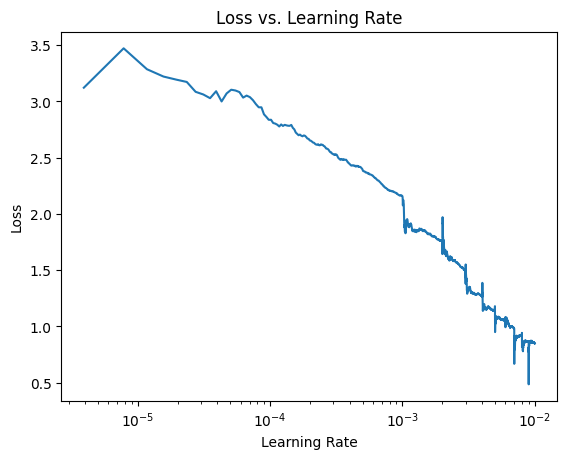

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir, lr=[1e-4, 1e-3])
histories.append(history2)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.7013
Epoch 1: val_loss improved from inf to 1.07193, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 104s 402ms/step - loss: 0.7989 - accuracy: 0.7013 - val_loss: 1.0719 - val_accuracy: 0.6713
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7032
Epoch 2: val_loss improved from 1.07193 to 0.98818, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 97s 379ms/step - loss: 0.7858 - accuracy: 0.7032 - val_loss: 0.9882 - val_accuracy: 0.6956
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7100
Epoch 3: val_loss improved from 0.98818 to 0.95300, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 96s 373ms/step - loss: 0.7861 - accuracy: 0.7100 - val_loss: 0.9530 - val_accuracy: 0.7066
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.7220
Epoch 4: val_loss improved from 0.95300 to 0.93590, saving model to ../../models/best_model_iteration_5_2.h5
256/256 [==============================] - 90s 351ms/step - loss: 0.7515 - accuracy: 0.7220 - val_loss: 0.9359 - val_accuracy: 0

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6893861792426973
Accuracy on test set: 0.7453703880310059
F1 Score: 0.7537624875609487


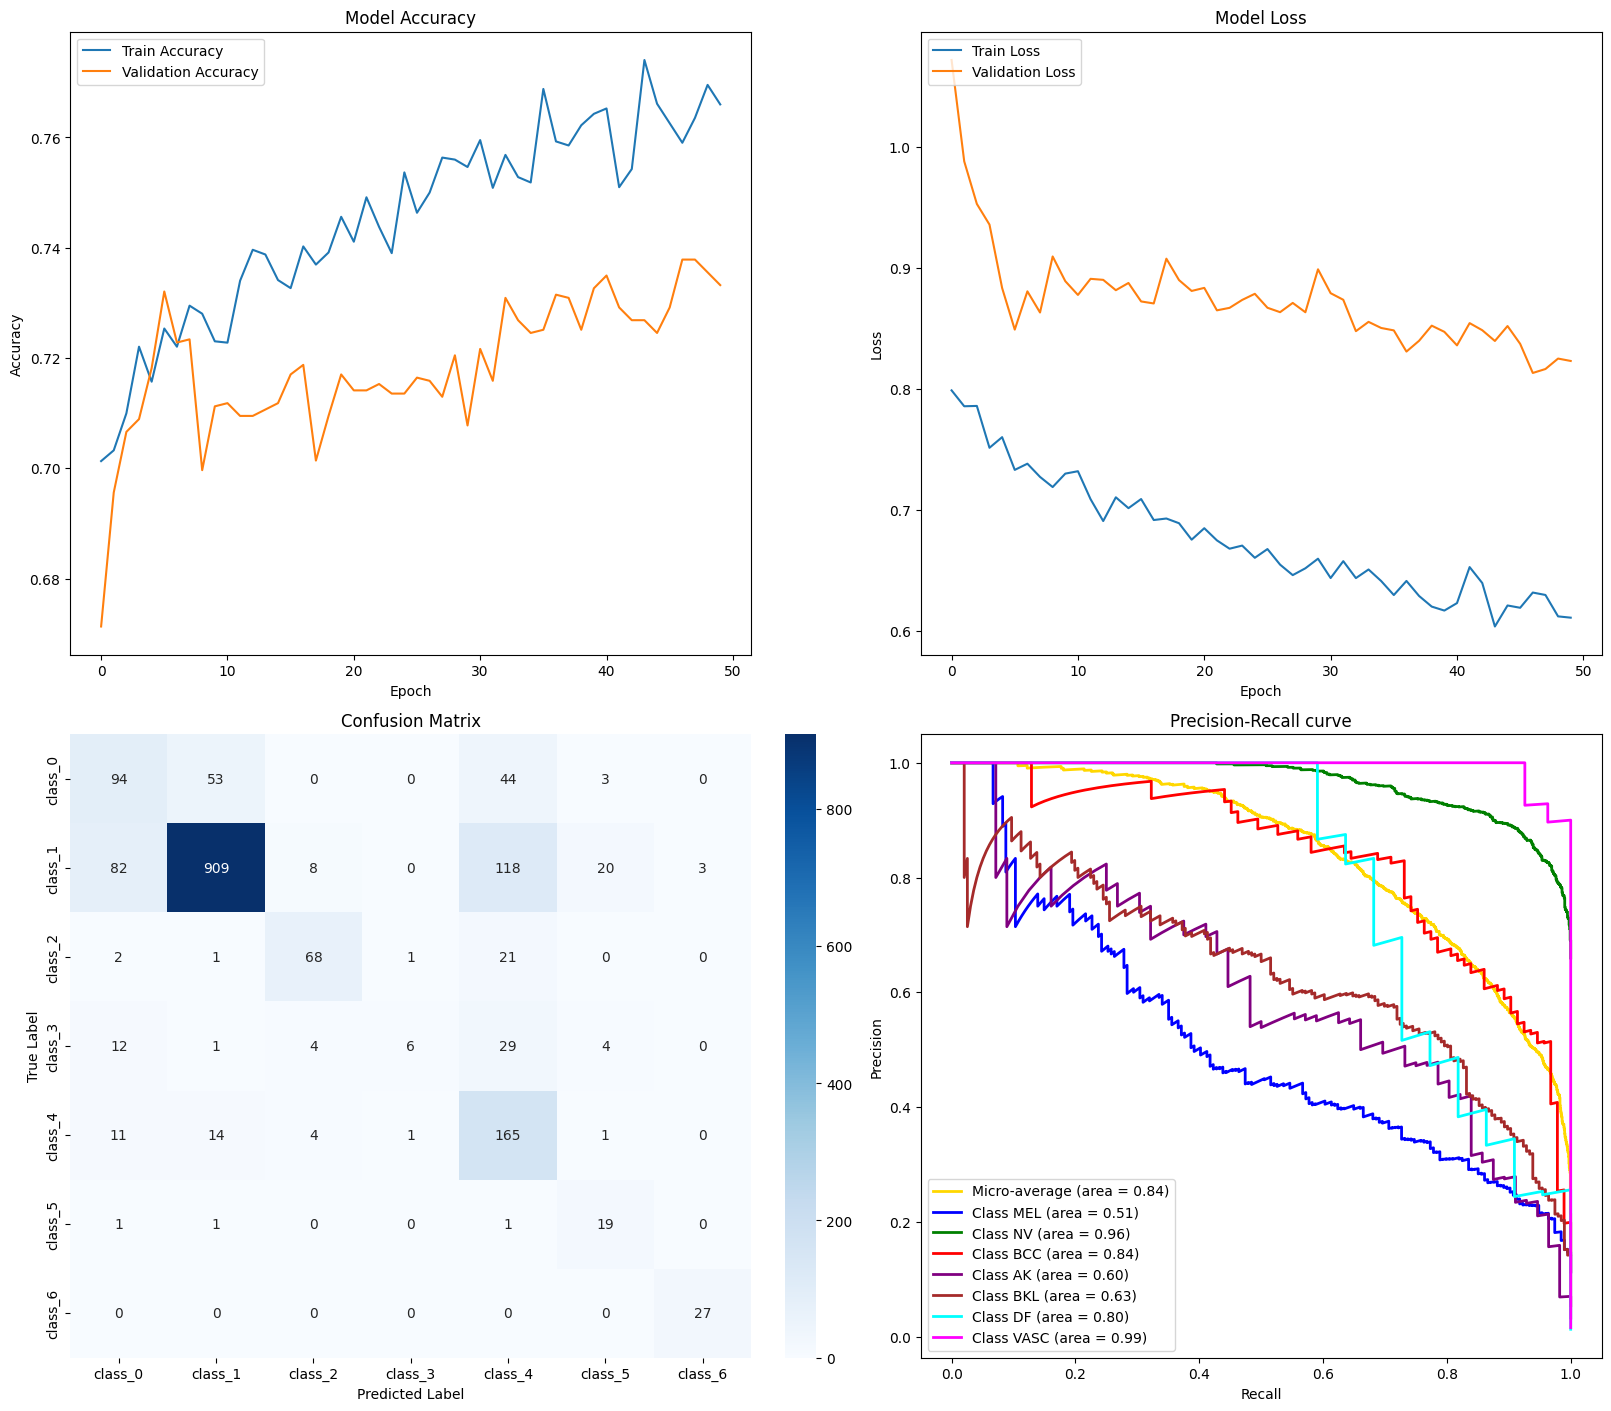

In [ ]:

from plot_utils import show_all_plots
from tensorflow.keras.models import load_model

m = load_model(model_dir)
histories = [history1, history2]
show_all_plots(history2, m, test_generator)

# Augmentations to do

### Test which augmentations should be valid

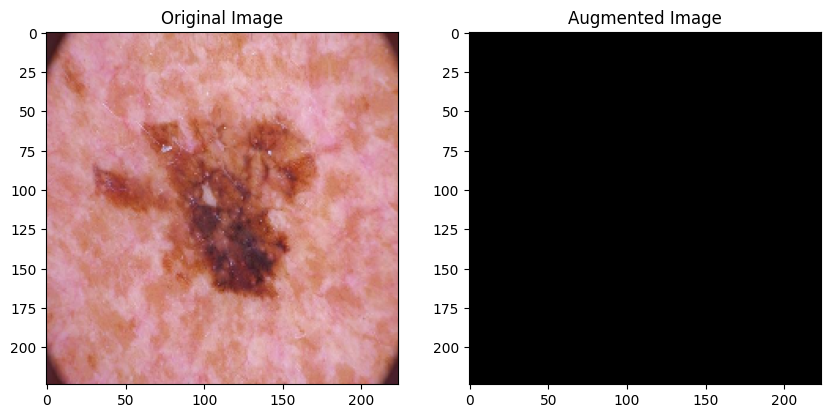

In [243]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define the data generator with your specified augmentations
datagen = ImageDataGenerator(
)

#shear_range=50, widht/height 0.2, roation_range=360, brightness_range=[0.3, 1.8], channel_shift_range= random.uniform(20, 50),zoom_range=0.3,


def augment_and_display_image(image_path, datagen):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    input_array = img_to_array(image)  # Convert image to array
    input_array = np.expand_dims(input_array, 0)  # Add batch dimension

    # Generate an augmented image
    augmented_iter = datagen.flow(input_array, batch_size=1)
    augmented_image = next(augmented_iter)[0].astype('uint8')

    # Plot the original and augmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.show()

# Example usage:
image_path = os.path.join(train_dir, "class_0/image_4.jpg")  # Replace with the actual image file path
augment_and_display_image(image_path, datagen)
